In [27]:
import pandas as pd
import numpy as np
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import sys
sys.path.append("..")
import utils
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics

In [31]:
def MAE_relative(y,pred):# assume input as arrays
    return round(abs(1-pred/y).mean(),4)

In [29]:
features_colname = ['year','odometer','income_rank','median_income',
       'cylinders_onehot_1', 'cylinders_onehot_2', 'cylinders_onehot_3',
       'cylinders_onehot_4', 'cylinders_onehot_5', 'cylinders_onehot_6',
       'cylinders_onehot_7', 'cylinders_onehot_8', 'type_onehot_1',
       'type_onehot_2', 'type_onehot_3', 'type_onehot_4', 'type_onehot_5',
       'type_onehot_6', 'type_onehot_7', 'type_onehot_8', 'type_onehot_9',
       'type_onehot_10', 'type_onehot_11', 'type_onehot_12', 'type_onehot_13',
       'type_onehot_14','drive_onehot_1', 'drive_onehot_2', 'drive_onehot_3',
       'drive_onehot_4', 'title_status_mean_price', 'title_status_median_price', 
       'title_status_price_std','manufacturer_mean_price','manufacturer_median_price', 'condition_mean_price',
       'condition_median_price', 'condition_price_std', 'manufacturer_price_std',
       'manufacturer_make_mean_price','manufacturer_make_median_price', 'manufacturer_make_price_std',
       'transmission_encoded', 'fuel_encoded', 'year_mean_price', 'year_median_price', 'year_price_std']


file_folder = '../data'
data_all_IS = pd.read_csv(f'{file_folder}/IS/data_with_grouping_operations_IS.csv')
data_all_OS = pd.read_csv(f'{file_folder}/OS/data_with_grouping_operations_OS.csv')

X = data_all_IS[features_colname]

zscore_cols = ['odometer', 'median_income', 'manufacturer_mean_price', 'manufacturer_median_price','condition_mean_price','condition_median_price', 'condition_price_std', 
       'manufacturer_price_std', 'manufacturer_make_mean_price', 'manufacturer_make_median_price', 'manufacturer_make_price_std', 'title_status_mean_price', 'title_status_median_price', 'title_status_price_std','year_mean_price', 'year_median_price', 'year_price_std']
positive_cols = ['income_rank']

X = utils.scaling(X,data_all_IS,zscore_cols,positive_cols)
X = utils.clean_df(X)

X_os = data_all_OS[features_colname]

# scaling
X_os = utils.scaling(X_os,data_all_IS,zscore_cols,positive_cols)
X_os = utils.clean_df(X_os,X)

y = pd.DataFrame(data_all_IS['price'])
y = utils.clean_df(y)

In [39]:
n_fold = 5
kf = KFold(n_splits=n_fold)
index=list(kf.split(y))

r = np.zeros((4,3))
d = [15, 20, 25, 30]
s = [20, 30, 40]


In [40]:
for i in range(4):
    for j in range(3):
        dt_paras={
            "criterion":"mse",
            "max_depth":d[i],
            "min_samples_split":s[j]
        }

        oof = np.zeros(len(X))
        prediction = np.zeros(len(X_os))


        for train_index, test_index in index:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model = DecisionTreeRegressor(**dt_paras)
            model.fit(X_train,y_train)
            y_pred_test = model.predict(X_test)
            y_pred_os = model.predict(X_os)
            oof[test_index] = y_pred_test.reshape(-1, )
            prediction += y_pred_os

        prediction /= n_fold
        IS_error = MAE_relative(np.array(y).flatten(),oof)
        r[i,j]= IS_error

# print("Writing files...")
# out_dt = pd.DataFrame([])
# out_dt['OS_predicted_price'] = prediction
# out_dt.to_csv(f'{file_folder}/output/OS_prediction_dt_1.csv', index=False)

# is_dt = pd.DataFrame([])
# is_dt['IS_predicted_price'] = oof
# is_dt.to_csv(f'{file_folder}/output/IS_prediction_dt_1.csv', index=False)
# print("len(OS)",len(out_dt))
# print("len(IS)",len(is_dt))


In [41]:
print(r)

[[0.3299 0.3307 0.3313]
 [0.3122 0.3136 0.3143]
 [0.3102 0.3108 0.3116]
 [0.3104 0.3106 0.3111]]


In [42]:
n_fold = 5
kf = KFold(n_splits=n_fold)
index=list(kf.split(y))

dt_paras={
    "criterion":"mse",
    "max_depth":25,
    "min_samples_split":20
}

oof = np.zeros(len(X))
prediction = np.zeros(len(X_os))


for train_index, test_index in index:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = DecisionTreeRegressor(**dt_paras)
    model.fit(X_train,y_train)
    y_pred_test = model.predict(X_test)
    y_pred_os = model.predict(X_os)
    oof[test_index] = y_pred_test.reshape(-1, )
    prediction += y_pred_os

prediction /= n_fold


print("Writing files...")
out_dt = pd.DataFrame([])
out_dt['OS_predicted_price'] = prediction
out_dt.to_csv(f'{file_folder}/output/OS_prediction_dt_1.csv', index=False)

is_dt = pd.DataFrame([])
is_dt['IS_predicted_price'] = oof
is_dt.to_csv(f'{file_folder}/output/IS_prediction_dt_1.csv', index=False)
print("len(OS)",len(out_dt))
print("len(IS)",len(is_dt))

Writing files...
len(OS) 46746
len(IS) 420715


In [44]:
import matplotlib.pyplot as plt

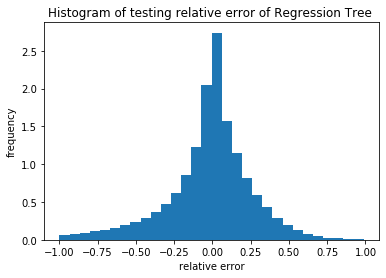

In [65]:
error_seq = 1-oof/np.array(y).flatten()
plt.hist(error_seq[abs(error_seq)<1],bins=30,density=1)
plt.xlabel("relative error")
plt.ylabel("frequency")
plt.title("Histogram of testing relative error of Regression Tree ")
plt.show()

In [53]:
len(error_seq[error_seq>3])

4151